In [1]:
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import numpy as np


In [2]:
from src.battery import Battery
from src.optimize import run_simulation
from src.load_data import load_data
from src.plot import display_schedule, display_profit, get_stats

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)




# Battery specs :



- SOC: practical state of charge in [0,1] 
- NEC: practical nominal energy capacity (Wh)
- CR: Charging rate (W/Wh)
- DR: Discharging rate (W/Wh)





In [3]:
SOC = np.array([0, 0.01, 0.85, 1.])

# Charging curve
CR = np.array([0.25, 0.5, 0.5, 0.1])

SOC_to_CR_function = interp1d(SOC, CR)

# Discharging curve
SOC = np.array([0., 0.15, 0.99, 1.])
DR = np.array([0.1, 0.5, 0.5, 0.25])

SOC_to_DR_function = interp1d(SOC, DR)

bat = Battery(SOC_to_CR_function, SOC_to_DR_function)


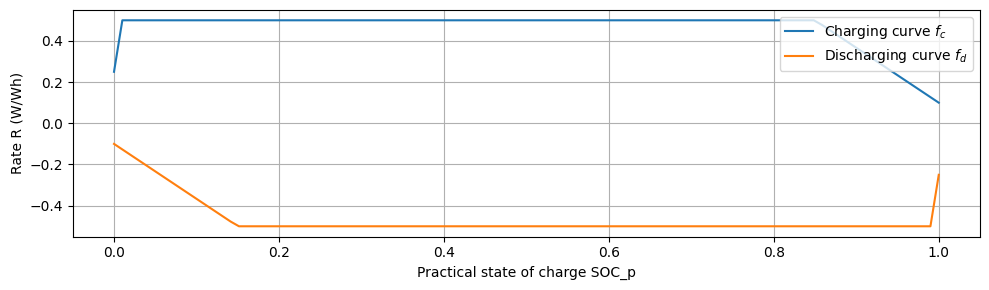

In [4]:
plt.figure(figsize=(10, 3))
plt.plot(np.linspace(0, 1, 100), SOC_to_CR_function(np.linspace(0, 1, 100)), label="Charging curve $f_c$")
plt.plot(np.linspace(0, 1, 100), -SOC_to_DR_function(np.linspace(0,1, 100)), label="Discharging curve $f_d$")
plt.grid(True)
plt.xlabel("Practical state of charge SOC_p")
plt.ylabel("Rate R (W/Wh)")
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig('out/charging_curve.pdf')
plt.show()


# Compute max SOC change in one hour of charge/ discharge

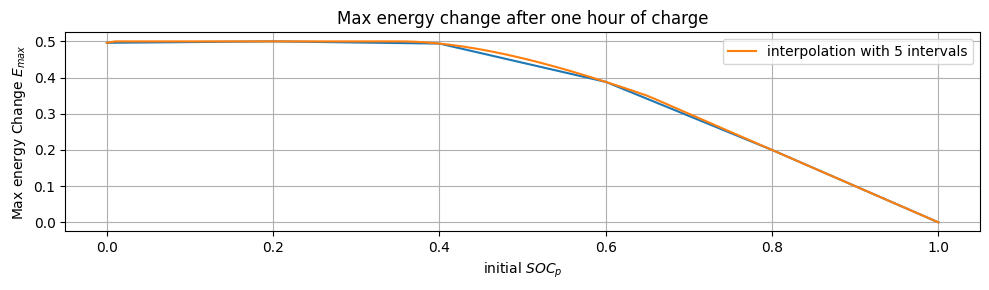

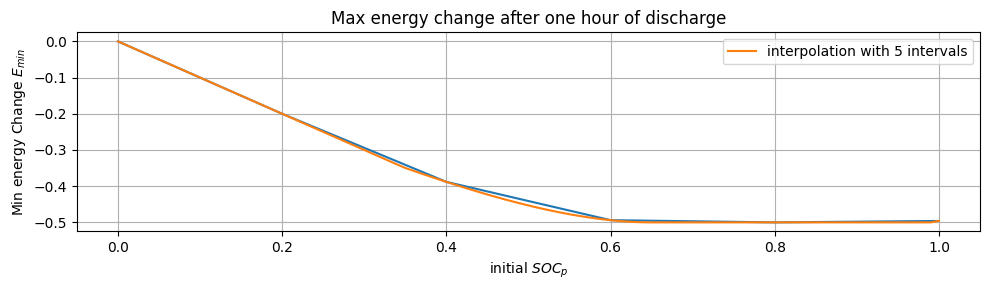

In [5]:
Nint = 5
G_c, G_d = bat.get_max_SOC_change(Nint)


Nint2 = 100
G_c2, G_d2 = bat.get_max_SOC_change(Nint2)

plt.figure(figsize=(10, 3))
plt.grid(True)
plt.plot(np.linspace(0, 1, Nint+1), G_c)
plt.plot(np.linspace(0, 1, Nint2+1), G_c2,
         label="interpolation with {} intervals".format(Nint))
plt.ylabel("Max energy Change $E_{max}$")
plt.xlabel("initial $SOC_p$")
plt.title("Max energy change after one hour of charge")
plt.legend()
plt.tight_layout()
plt.savefig("out/max_energy_change.pdf")
plt.show()


plt.figure(figsize=(10, 3))
plt.grid(True)
plt.plot(np.linspace(0, 1, Nint+1), G_d)
plt.plot(np.linspace(0, 1, Nint2+1), G_d2,
         label="interpolation with {} intervals".format(Nint))
plt.ylabel("Min energy Change $E_{min}$")
plt.xlabel("initial $SOC_p$")
plt.title("Max energy change after one hour of discharge")
plt.legend()
plt.tight_layout()
plt.savefig("out/min_energy_change.pdf")
plt.show()


# Dataset :

In [7]:
for country in ["Germany","France","Austria","Denmark","Spain", "Italy"] :
    df = load_data(country=country, start="2021-01-01 00:00:00")
    frame_size_forecast = 28
    update_period = 1

    df_optim = run_simulation(bat,
                            start = "2022-01-01 00:00:00",
                            end = "2023-01-01 00:00:00",
                            df = df,
                            forecasted=False,
                            frame_size=frame_size_forecast,
                            update_period=update_period)


    display_schedule(df_optim,name = country+'_optim_'+str(frame_size_forecast))
    display_profit(df_optim,name= country+'_optim_'+str(frame_size_forecast))

    df_pred = run_simulation(bat,
                            start = "2022-01-01 00:00:00",
                            end = "2023-01-01 00:00:00",
                            df = df,
                            forecasted=True,
                            frame_size=frame_size_forecast,
                            update_period=update_period)
    
    display_schedule(df_pred,name = country+'_pred_'+str(frame_size_forecast))
    display_profit(df_pred,name= country+'_pred_'+str(frame_size_forecast))
    get_stats(df_pred, df_optim, name=country+'_' +str(frame_size_forecast)) 





,Country,ISO3 Code,timestamp,Datetime (Local),price_euros_wh,vgc,fgc
387912,Germany,DEU,2021-01-01 00:00:00,2021-01-01 01:00:00,0.000048,0.000005,0
387913,Germany,DEU,2021-01-01 01:00:00,2021-01-01 02:00:00,0.000045,0.000005,0
387914,Germany,DEU,2021-01-01 02:00:00,2021-01-01 03:00:00,0.000043,0.000005,0
387915,Germany,DEU,2021-01-01 03:00:00,2021-01-01 04:00:00,0.000040,0.000005,0
387916,Germany,DEU,2021-01-01 04:00:00,2021-01-01 05:00:00,0.000040,0.000005,0
...,...,...,...,...,...,...,...
405427,Germany,DEU,2022-12-31 19:00:00,2022-12-31 20:00:00,0.000023,0.000005,0
405428,Germany,DEU,2022-12-31 20:00:00,2022-12-31 21:00:00,-0.000001,0.000005,0
405429,Germany,DEU,2022-12-31 21:00:00,2022-12-31 22:00:00,-0.000001,0.000005,0
405430,Germany,DEU,2022-12-31 22:00:00,2022-12-31 23:00:00,0.000025,0.000005,0
